In [116]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sn
import pandas as pd
import scipy.signal as ss
import tensorflow.keras as keras
import pickle

from tqdm import tqdm
from mpl_toolkits.axes_grid1 import Grid
from mnist import Mnist
from crbm import CRBM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [2]:
# get data from MNIST dataset
mnist = Mnist()
train_X, train_label = mnist.get_trainset(norm=True)
train_img = mnist.reshape_dataset(train_X)
test_X, test_label = mnist.get_testset(norm=True)
test_img = mnist.reshape_dataset(test_X)

In [3]:
crbm = CRBM(mnist.IMG_SIZE, num_filters=40, filters_size=7, pooling_size=3)

In [5]:
crbm.train_cd(train_img, learning_rate=0.01, k=1, target_sparsity=np.ones(crbm.num_filters)*0.01)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [1:48:07<00:00,  9.25it/s]


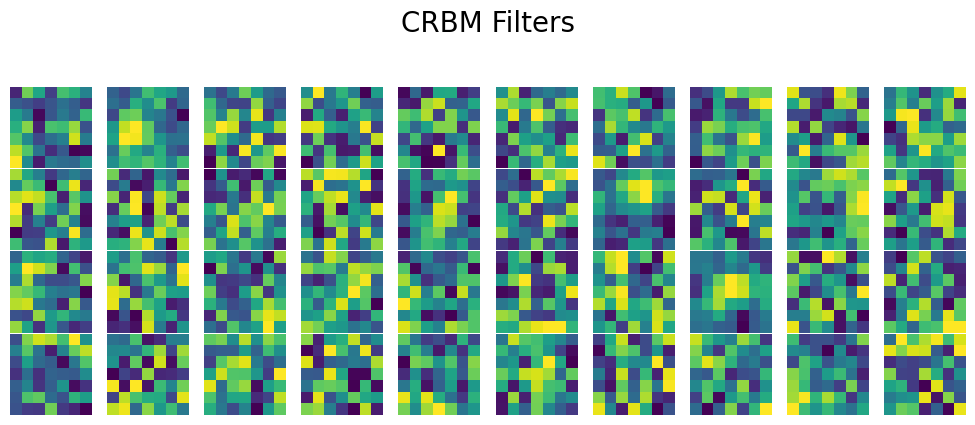

In [6]:
crbm.show_filters()

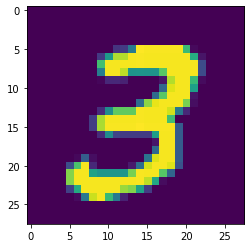

In [16]:
V = train_img[7]
plt.imshow(V)

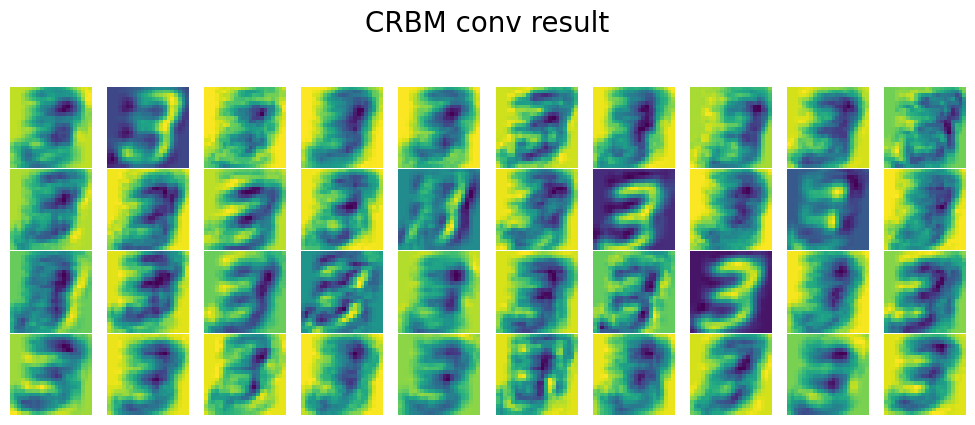

In [17]:
r = np.array([ss.convolve(V, crbm.W[k, ::-1, ::-1], 'valid') + crbm.hb[k] for k in range(crbm.num_filters)])

ncols = crbm.num_filters if crbm.num_filters < 10 else 10
nrows = crbm.num_filters//ncols
fig = plt.figure(figsize=(ncols, nrows), dpi=100)
grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

for i, ax in enumerate(grid):
    x = r[i]
    ax.imshow(x)
    ax.set_axis_off()

fig.suptitle('CRBM conv result', size=20, y=1.05)
fig.tight_layout()
fig.subplots_adjust(top=0.85 + nrows*0.002)
plt.show()

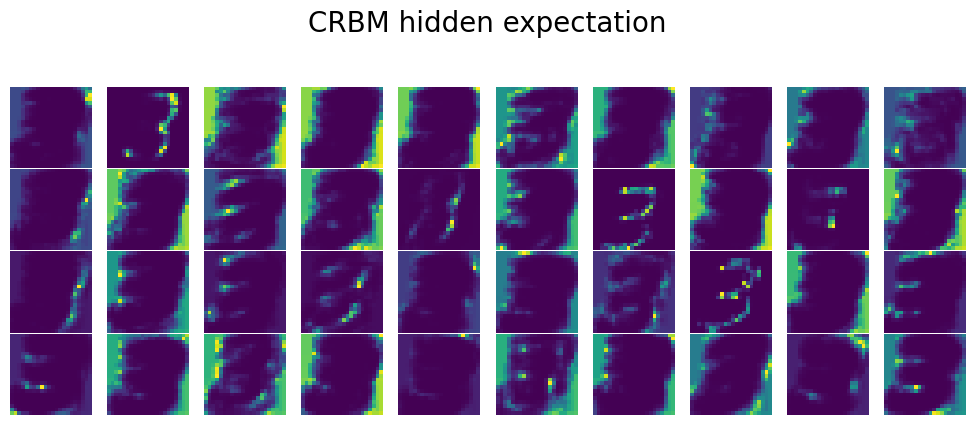

In [18]:
r2 = crbm.hidden_expectation(V)

ncols = crbm.num_filters if crbm.num_filters < 10 else 10
nrows = crbm.num_filters//ncols
fig = plt.figure(figsize=(ncols, nrows), dpi=100)
grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

for i, ax in enumerate(grid):
    x = r2[i]
    ax.imshow(x)
    ax.set_axis_off()

fig.suptitle('CRBM hidden expectation', size=20, y=1.05)
fig.tight_layout()
fig.subplots_adjust(top=0.85 + nrows*0.002)
plt.show()

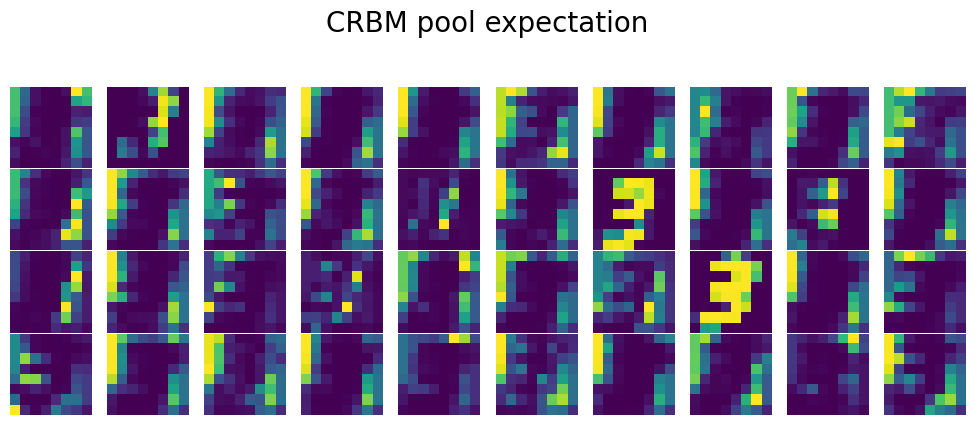

In [19]:
p = crbm.pooling_expectation(V)

ncols = crbm.num_filters if crbm.num_filters < 10 else 10
nrows = crbm.num_filters//ncols
fig = plt.figure(figsize=(ncols, nrows), dpi=100)
grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

for i, ax in enumerate(grid):
    x = p[i]
    ax.imshow(x)
    ax.set_axis_off()

fig.suptitle('CRBM pool expectation', size=20, y=1.05)
fig.tight_layout()
fig.subplots_adjust(top=0.85 + nrows*0.002)
plt.show()

In [11]:
p.shape

(40, 8, 8)

In [22]:
n_sample = train_img.shape[0]
onehot_train_label = np.zeros((n_sample, 10))
encoded_train_X = np.empty((n_sample, *p.shape))
for i in tqdm(range(n_sample)):
    encoded_train_X[i] = crbm.pooling_expectation(train_img[i])
    onehot_train_label[i][train_label[i]] = 1
    
n_sample = test_img.shape[0]
encoded_test_X = np.empty((n_sample, *p.shape))
for i in tqdm(range(n_sample)):
    encoded_test_X[i] = crbm.pooling_expectation(test_img[i])

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:07<00:00, 53.42it/s]


In [24]:
model = Sequential()
model.add(Flatten(input_shape=p.shape))
model.add(Dropout(0.5))
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(300, activation="relu"))
model.add(Dense(10, activation="softmax"))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              2561000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               300300    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 2,864,310
Trainable params: 2,864,310
Non-trainable params: 0
______________________________________________

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_history = model.fit(encoded_train_X, onehot_train_label, batch_size=8, epochs=50, validation_split=0.1, verbose=1)

Epoch 1/50
6750/6750 [==============================] - 83s 12ms/step - loss: 0.3509 - accuracy: 0.8880 - val_loss: 0.1041 - val_accuracy: 0.9697
Epoch 2/50
6750/6750 [==============================] - 107s 16ms/step - loss: 0.2475 - accuracy: 0.9237 - val_loss: 0.0907 - val_accuracy: 0.9710
Epoch 3/50
6750/6750 [==============================] - 146s 22ms/step - loss: 0.2235 - accuracy: 0.9330 - val_loss: 0.0815 - val_accuracy: 0.9760
Epoch 4/50
6750/6750 [==============================] - 159s 24ms/step - loss: 0.2147 - accuracy: 0.9364 - val_loss: 0.0867 - val_accuracy: 0.9763
Epoch 5/50
6750/6750 [==============================] - 159s 24ms/step - loss: 0.2075 - accuracy: 0.9399 - val_loss: 0.0911 - val_accuracy: 0.9750s - loss: 0
Epoch 6/50
6750/6750 [==============================] - 157s 23ms/step - loss: 0.1955 - accuracy: 0.9441 - val_loss: 0.0756 - val_accuracy: 0.9795
Epoch 7/50
6750/6750 [==============================] - 158s 23ms/step - loss: 0.1923 - accuracy: 0.9440 - v

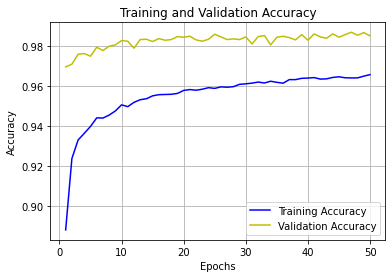

In [26]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

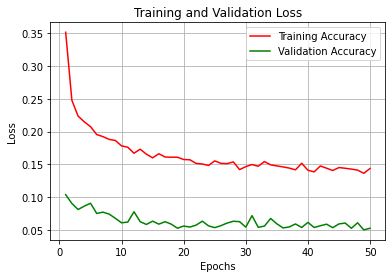

In [27]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training Accuracy')
plt.plot(epochs, val_loss, 'g', label='Validation Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [28]:
predictions = model.predict(encoded_test_X)
correct = 0
n_sample, size = predictions.shape
confusion_matrix = np.zeros((10, 10))
errors = {}
for i in range(predictions.shape[0]):
    pred = np.argmax(predictions[i])
    if pred == test_label[i]:
        correct += 1
    elif (pred, test_label[i]) in errors:
        errors[(pred, test_label[i])].append(i)
    else:
        errors[(pred, test_label[i])] = [i]
    confusion_matrix[pred][test_label[i]] += 1
print("Accuracy: ", correct/n_sample)

Accuracy:  0.9839


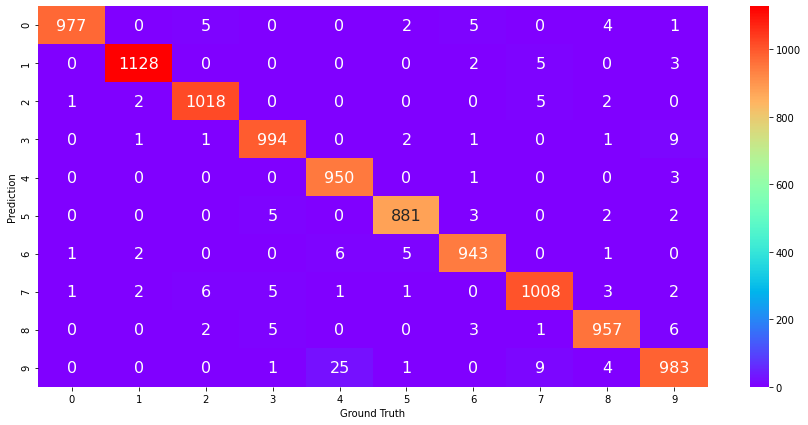

In [29]:
df_cm = pd.DataFrame(confusion_matrix, range(10), range(10))
# sn.set(font_scale=1.4) # for label size
plt.figure(figsize=(15,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=mat.cm.rainbow, fmt='g') # font size
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()

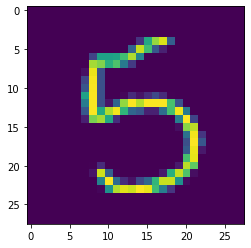

In [107]:
V = test_img[53]
# V = test_img[errors[(9,4)][0]]
plt.imshow(V)

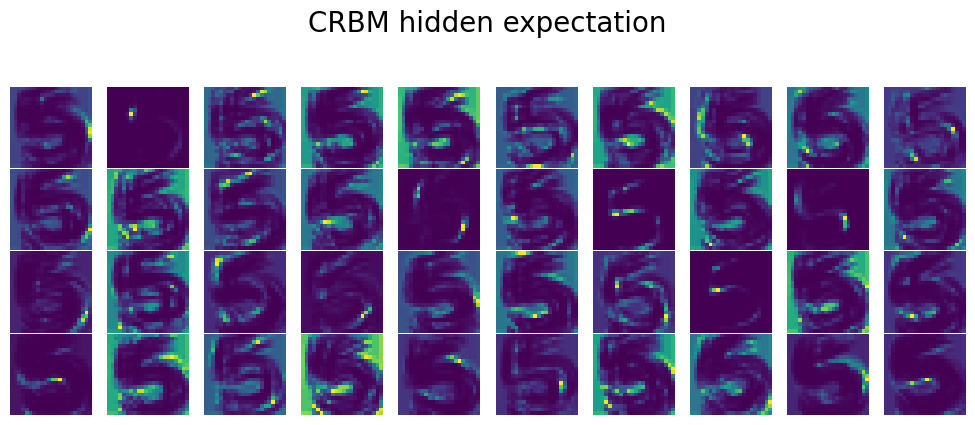

In [108]:
res_hidden = crbm.hidden_expectation(V)

ncols = crbm.num_filters if crbm.num_filters < 10 else 10
nrows = crbm.num_filters//ncols
fig = plt.figure(figsize=(ncols, nrows), dpi=100)
grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

for i, ax in enumerate(grid):
    x = res_hidden[i]
    ax.imshow(x)
    ax.set_axis_off()

fig.suptitle('CRBM hidden expectation', size=20, y=1.05)
fig.tight_layout()
fig.subplots_adjust(top=0.85 + nrows*0.002)
plt.show()

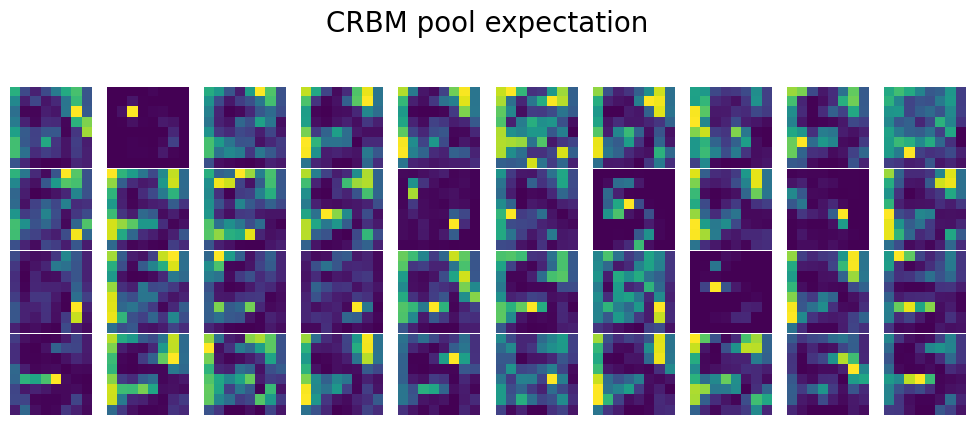

In [109]:
res_pool = crbm.pooling_expectation(V)

ncols = crbm.num_filters if crbm.num_filters < 10 else 10
nrows = crbm.num_filters//ncols
fig = plt.figure(figsize=(ncols, nrows), dpi=100)
grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

for i, ax in enumerate(grid):
    x = res_pool[i]
    ax.imshow(x)
    ax.set_axis_off()

fig.suptitle('CRBM pool expectation', size=20, y=1.05)
fig.tight_layout()
fig.subplots_adjust(top=0.85 + nrows*0.002)
plt.show()

In [110]:
model.predict(np.array([res_pool]))

array([[7.0742476e-07, 1.4970420e-05, 6.7581967e-09, 2.3402408e-04,
        1.6970867e-08, 9.9957460e-01, 4.0262246e-05, 5.8925163e-08,
        1.1529261e-04, 2.0055728e-05]], dtype=float32)

---

In [118]:
model.save("models/CRBM_classifier")

INFO:tensorflow:Assets written to: models/CRBM_classifier\assets


In [122]:
d = {'num_filters':crbm.num_filters, 'input_shape':crbm.input_shape, 'filters_shape':crbm.filters_shape, 
     'pooling_shape':crbm.pooling_shape, 'W':crbm.W, 'hb':crbm.hb, 'vb':crbm.vb, 'k':crbm.k, 
     'sparsity':np.ones(crbm.num_filters)*0.01}
save_file = "CRBM."+ str(crbm.num_filters) + "x" + str(crbm.filters_shape)
with open(save_file, 'wb') as f:
    pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)